working

In [54]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

import sys
sys.path.append('./datasets/')

from datasets.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    
import random

In [55]:
print(torch.__version__)




2.0.1+cu117


In [56]:
def get_femnist_shakespeare_dataset(**args):
    if args['dataset'] == 'femnist' or args['dataset'] == 'shakespeare':
        trainloader, testloader = get_LEAF_dataloader(dataset=args['dataset'],
                                                      client_id=args['rank'])
    else:
        raise ValueError("Invalid dataset:", args['dataset'])
    return trainloader, testloader
    # PickleDataset('femnist')
    

In [57]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 62
epoch_total = 500
pickle_name = "femnist-p2p-epoch-"+str(epoch_total)

for i in range(num_nodes):
    args = {'dataset': 'femnist', 'rank': i}
    trainloader, testloader = get_femnist_shakespeare_dataset(**args)
    train_loaders.append(trainloader)
    test_loaders.append(testloader)

In [58]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [59]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(x,num_class).float()

In [60]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [61]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x000001A5D0E0C2E0>, <torch.utils.data.dataloader.DataLoader object at 0x000001A5D0E0C430>, <torch.utils.data.dataloader.DataLoader object at 0x000001A569008790>, <torch.utils.data.dataloader.DataLoader object at 0x000001A5518624A0>, <torch.utils.data.dataloader.DataLoader object at 0x000001A5518625C0>]
35


In [62]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [63]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 62)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = correct / total
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        outputs = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            outputs.append(output.clone().detach())
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            data_y = target_transform(data_y)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = correct / total
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        self.test_loss = self.criterion(target_transform(torch.tensor(labels, device=device)).float(), torch.cat(outputs, dim=-1)).item()
        #print("test loss ",self.test_loss)
       
    def f1pred(self):
        pred_test = []
        y_label = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            y=self.network(data_x.to(device))
            
            y = torch.argmax(y, dim=1)
            pred_test.append(y)
            
            # data_y = torch.argmax(data_y, dim=1)
            y_label.append(data_y)
        pred_test = torch.cat(pred_test)
        y_label = torch.cat(y_label)
        return pred_test, y_label
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
                
        
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])

    def share_x_ij_neighbours(self, neighbour_nodes):
        j=self.node_id
        num_neighbour_nodes = len(neighbour_nodes)
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_neighbour_nodes])
        s_r = torch.sum(r)
        
        for i, n in enumerate(neighbour_nodes):
            x_i_j[(n,j)]={}
            for key in x.keys():
                x_i_j[(n,j)][key]=x[key]*r[i]/s_r

    def share_s_i_neighbours(self, neighbour_nodes):
        i = self.node_id
        s_i[i] = {}
        
        for key in x_i_j[list(x_i_j.keys())[0]].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in neighbour_nodes])


    def share_FedavgP2P(self, nodes):
        dataset_size_all = [n.dataset_size for n in nodes]
        i = self.node_id
        C = 0.5
        A = num_nodes - 1
        m = C*A
        #n_k = self.dataset_size

        # Random clients
        S_t = random.sample([ j for j in range(num_nodes) if j!=i], int(m)) 
        S_t.append(self.node_id)
        #print("Clients ",S_t)
        #S_t = random.sample(list(range(num_nodes)) , int(m))
        #print("n_k ",n_k)
        #print("m neighbors", m)
        #print("S_t", S_t)
        w_c = self.network.state_dict()
        n_c = self.dataset_size
        n_t = n_c
        for s in S_t:
            n_t += dataset_size_all[s]
                
        for key in nodes[0].network.state_dict():

            for j in S_t: 
                n_k = dataset_size_all[j]
                #states = nodes[j].network.state_dict()
                averaged_state = {}
            
                for key in self.network.state_dict().keys():
                    param_value = 0
                    for i in S_t:
                        param_value += nodes[i].network.state_dict()[key]
                    
                    averaged_state[key] = param_value/len(S_t)
                #print(averaged_state)
                contributed_state = averaged_state[key]
                w_c[key] = contributed_state
                
        self.network.load_state_dict(w_c)


In [64]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [65]:
losses = {}
train_accuracies = {}
test_accuracies = {}
test_losses = {}
f1_scores = {}
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
dataset_size_all = {}
epochs ={i:0 for i in range(num_nodes)}

for i in tqdm(range(epoch_total*num_nodes)):
    cands = [i for i in epochs if epochs[i]<epoch_total]
    node = nodes[cands[torch.randint(len(cands), (1,)).item()]]
    del cands
    train_acc, loss = node.train_epoch()
    node.share_FedavgP2P(nodes)


        
    
    epochs[node.node_id] += 1
    losses[(node.node_id, epochs[node.node_id])]=loss
    train_accuracies[(node.node_id, epochs[node.node_id])]=train_acc
    # print(f"node={node.node_id}, epoch={epochs[node.node_id]}, acc={train_acc}")
    # for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
    node.testing()
    #test_losses.append(node.test_loss)
    #print("Node Test Accuracy", node.test_accuracy)
    #print("Node Test loss", node.test_loss)
    #print("Node F1_Score ", node.f1_score)
    test_accuracies[(node.node_id, epochs[node.node_id])]=node.test_accuracy
    test_losses[(node.node_id, epochs[node.node_id])]=node.test_loss
    f1_scores[(node.node_id, epochs[node.node_id])]=node.f1_score
        



    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


100%|██████████| 2500/2500 [00:45<00:00, 55.10it/s]

Time taken by FL with SMPC 45.38986539840698


In [66]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [67]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)


0.48814222420058456


In [68]:
losses2 = [[losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
train_accuracies2 = [[train_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_accuracies2 = [[test_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_losses2 = [[test_losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
f1_scores2 = [[f1_scores[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]

In [69]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [70]:
result["train_accuracies"] = train_accuracies2
result["train_losses"] = losses2
result["test_accuracies"] = test_accuracies2
result["test_losses"] = test_losses2
result["f1_scores"] = f1_scores2
result["ypred_test"] = f1_y_test
result["ylabels_test"] = f1_y_label
result["time_taken"] = time_FL_SMPC
result["f1_global"] = f1_global
my_pickle_results["p2p"] = result

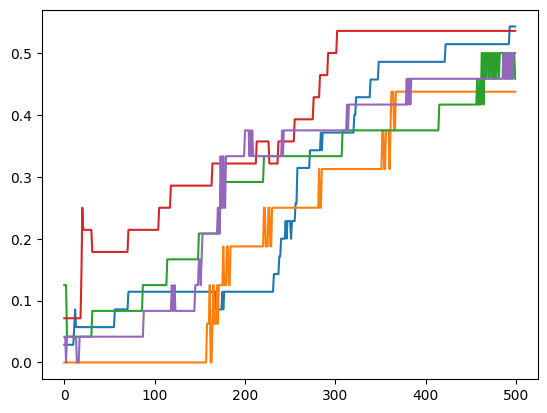

In [71]:
plt.plot(test_accuracies2)

In [72]:
print(losses2)

[[4.2233907381693525, 4.171553611755371, 4.2423789501190186, 4.178924322128296, 4.134418487548828], [4.046142578125, 4.014819025993347, 4.044220447540283, 4.024884462356567, 3.9513078927993774], [4.017230033874512, 3.9660463333129883, 3.995473027229309, 3.9760717153549194, 3.8940526247024536], [4.000818729400635, 3.9288302659988403, 3.9579615592956543, 3.9491711854934692, 3.8572291135787964], [3.9820690155029297, 3.894050121307373, 3.9286720752716064, 3.9258294105529785, 3.8303760290145874], [3.962096691131592, 3.8574254512786865, 3.901599407196045, 3.9035749435424805, 3.8052831888198853], [3.942021369934082, 3.819148302078247, 3.8766446113586426, 3.881660223007202, 3.781738758087158], [3.9221746921539307, 3.781219482421875, 3.8537285327911377, 3.860300660133362, 3.7573492527008057], [3.9026430447896323, 3.7441084384918213, 3.831786632537842, 3.840092182159424, 3.7329856157302856], [3.8828375339508057, 3.707467794418335, 3.811727285385132, 3.8210071325302124, 3.7114109992980957], [3.86

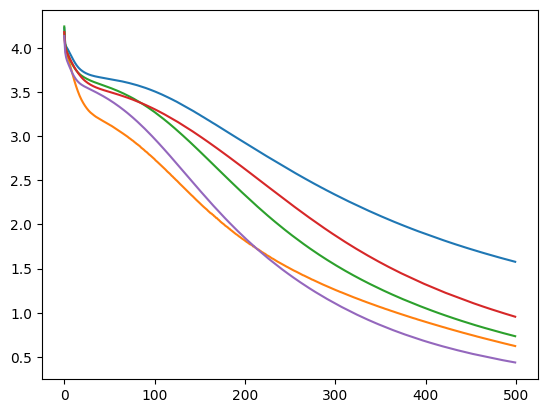

In [73]:
plt.plot(losses2)

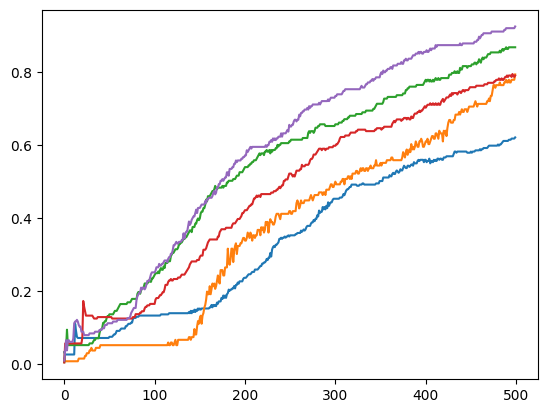

In [74]:
plt.plot(train_accuracies2)

In [76]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [77]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [79]:
#Testing pickle

import pickle

try:
    my_pickle_results3 = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result3 = {}
    result4 = {}
    myResults = my_pickle_results3
except (OSError, IOError) as e:
    my_pickle_results = {}
    resul3 = {}
    result4 = {}

print(my_pickle_results3["p2p"]["train_losses"])

[[4.2233907381693525, 4.171553611755371, 4.2423789501190186, 4.178924322128296, 4.134418487548828], [4.046142578125, 4.014819025993347, 4.044220447540283, 4.024884462356567, 3.9513078927993774], [4.017230033874512, 3.9660463333129883, 3.995473027229309, 3.9760717153549194, 3.8940526247024536], [4.000818729400635, 3.9288302659988403, 3.9579615592956543, 3.9491711854934692, 3.8572291135787964], [3.9820690155029297, 3.894050121307373, 3.9286720752716064, 3.9258294105529785, 3.8303760290145874], [3.962096691131592, 3.8574254512786865, 3.901599407196045, 3.9035749435424805, 3.8052831888198853], [3.942021369934082, 3.819148302078247, 3.8766446113586426, 3.881660223007202, 3.781738758087158], [3.9221746921539307, 3.781219482421875, 3.8537285327911377, 3.860300660133362, 3.7573492527008057], [3.9026430447896323, 3.7441084384918213, 3.831786632537842, 3.840092182159424, 3.7329856157302856], [3.8828375339508057, 3.707467794418335, 3.811727285385132, 3.8210071325302124, 3.7114109992980957], [3.86

In [80]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-14 19:15:42
